# plan
## phase 1
- read data for at_rest
- plot angular velocity
## phase 2

for i in (x,y,z)
- read data for i_motion
- plot angular velocity
- confirm that there is movement in the appropriate axis
## phase 3
- read data idle_15
- pass in magnitude of angular velocities
- plot idletime

In [22]:
from datetime import datetime
def convert(s, ms=False):
    denom = 1
    if ms:
        denom = 1000
    return datetime.fromtimestamp(s/denom)

In [23]:
def read_wm(file_name):
    elems = []
    with open(file_name, 'r') as fh:
        lines = fh.read().splitlines()[1:]
        for line in lines:
            l = line.split(',')
            ts = float(l[0])
            x = float(l[-3])
            y = float(l[-2])
            z = float(l[-1])
            elems.append({'x':x, 'y':y, 'z':z, 'ts':convert(ts, ms=True)})
    return elems

In [52]:
# read data
import os
read_path = '/Users/calvinperumalla/datasets/imu_vs_mm/imu_feb13/'
from glob import glob
from collections import defaultdict
data = defaultdict(dict)
for folder_name in os.listdir(read_path):
    if folder_name not in ('idle_15', 'y_motion', 'at_rest', 'z_motion', 'x_motion'):
        continue
    for file_path in glob(os.path.join(read_path, folder_name) + '/*'):
        if 'Acc' in file_path:
            data[folder_name]['acc'] = read_wm(file_path)
        if 'Gyr' in file_path:
            data[folder_name]['gyr'] = read_wm(file_path)
        else:
            data[folder_name]['mag'] = read_wm(file_path)

### &#9658; <font color=red> Observation: noise observed in at_rest signal. 20 peaks a second. Applied low pass filter at 5 hz

In [132]:
data.keys()

dict_keys(['idle_15', 'y_motion', 'at_rest', 'z_motion', 'x_motion'])

In [149]:
get_d = lambda m, t: list(zip(*[(elem['ts'], elem['x'], elem['y'], elem['z']) for elem in data[m][t]]))

def process(mode, sensor, cutoff=5, srate=100, order=3):
    def _lp(data, cutoff, srate, order):
        return butter_lowpass_filter(data, cutoff, srate, order)
    
    t, x, y, z = get_d(mode, sensor)
    return t[:-10], _lp(x, cutoff, srate, order)[:-10], _lp(y, cutoff, srate, order)[:-10], _lp(z, cutoff, srate, order)[:-10]
            
            
    
# times = [elem['ts'] for elem in data['at_rest']['gyr']]
# vals_x = [elem['x'] for elem in data['at_rest']['gyr']]
# vals_y = [elem['y'] for elem in data['at_rest']['gyr']]
# vals_z = [elem['z'] for elem in data['at_rest']['gyr']]

t, x, y, z = process('at_rest', 'gyr')
t_x_motion, x_x_motion, y_x_motion, z_x_motion = process('x_motion', 'gyr')
t_y_motion, x_y_motion, y_y_motion, z_y_motion = process('y_motion', 'gyr')
t_z_motion, x_z_motion, y_z_motion, z_z_motion = process('z_motion', 'gyr')

In [150]:
t_id, x_id, y_id, z_id = process('idle_15', 'gyr')

In [121]:
# Low Pass Filter
from scipy.signal import butter, filtfilt
def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order)
    y = filtfilt(b, a, data,axis=0)#,padtype='odd', padlen=3*(max(len(b),len(a))-1))
    return y

(-5.0, 5.0)

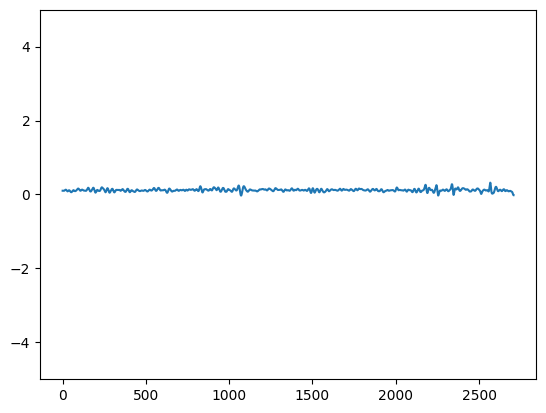

In [127]:
from matplotlib import pyplot as plt
#plt.plot(x)

plt.plot(x)
plt.ylim(-5, 5)

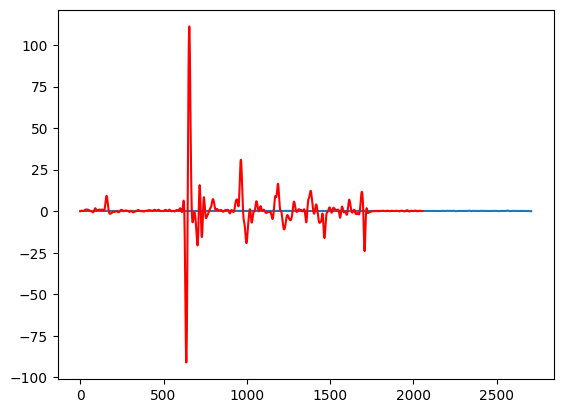

In [136]:
#plt.plot(x_y_motion)
#plt.plot(y_y_motion, 'g')
plt.plot(x, )
plt.plot(x_y_motion, c='r')


Text(0, 0.5, 'degrees/sec')

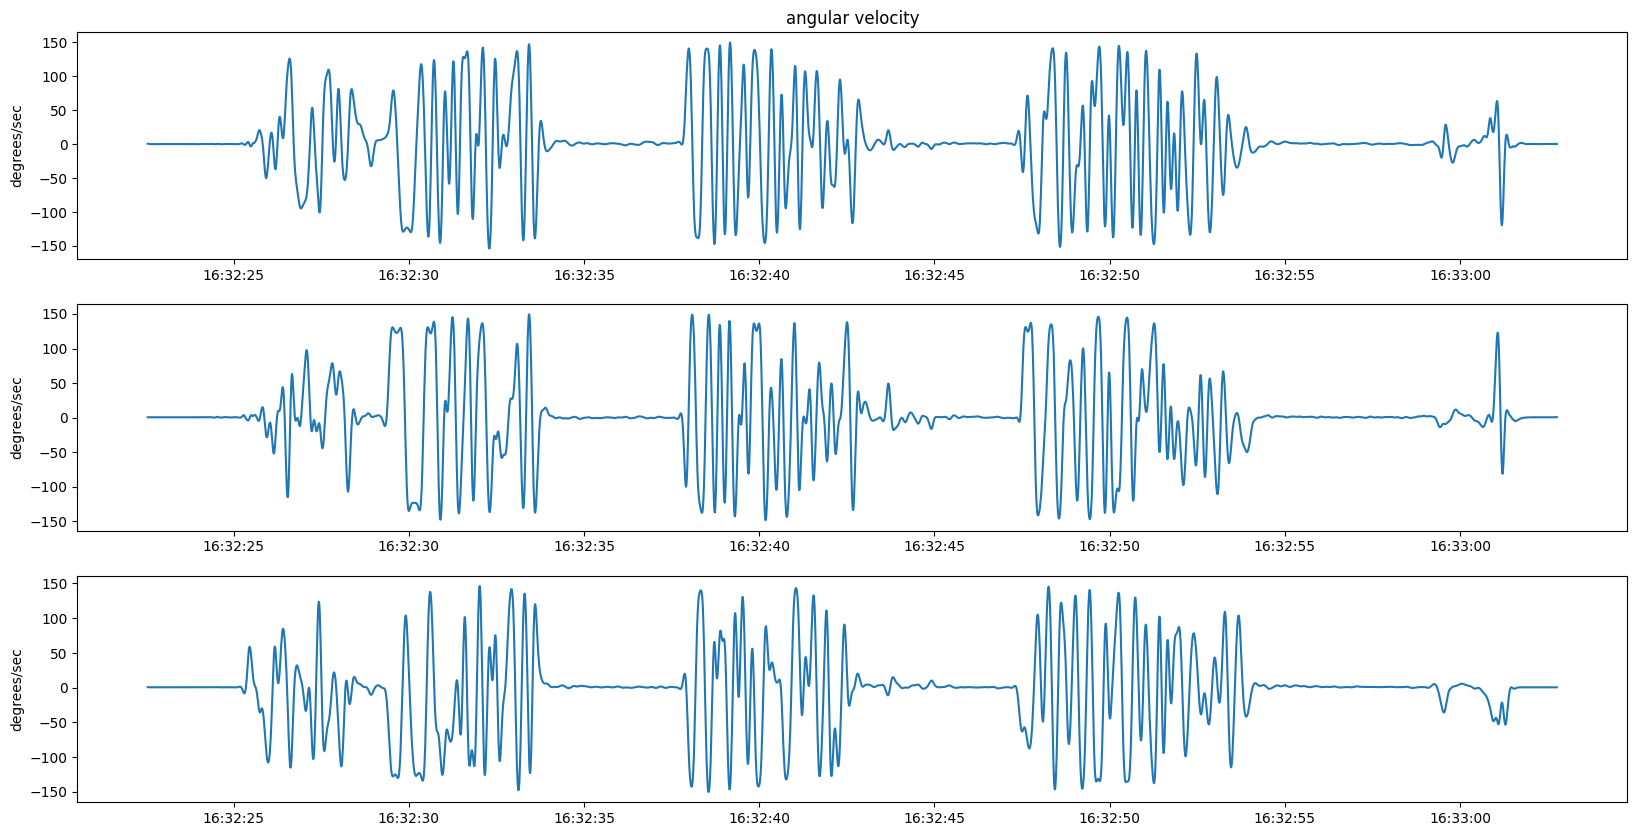

In [153]:
f, axs = plt.subplots(3,1, figsize=(20, 10))
axs[0].plot(t_id, x_id)
axs[0].set_title('angular velocity')
axs[0].set_ylabel('degrees/sec')

axs[1].plot(t_id, y_id)
axs[1].set_ylabel('degrees/sec')

axs[2].plot(t_id, z_id)
axs[2].set_ylabel('degrees/sec')

### &#9658; <font color=red> Observation: roughly 15 seconds worth of flat data is seen

## IDLE TIME FUNCTION

In [154]:
# Generate Idle Time Function
def generate_Idle_time(vel_res, parameters):
    threshold = parameters['IdleVelocityThreshold']/1000 # convert value to m/sec
    sf = parameters['SamplingFrequency']
    pause_duration = parameters['PauseDuration']
    
    mHand = vel_res
    
    # Convert pause duration into a sample window size based on sampling frequency
    Du = int(pause_duration*sf)
    
    
        
    # Calculate instances in which the velocity is below the velocity threshold
    a = np.zeros(len(mHand))
    
    for i in range(len(a)):
        if mHand[i] < threshold:
            a[i] = 1
            
    idle_instances = a

    # Caculate the toal time by adding time based on if the total duration of idle >= the pause duration
    b = np.ones(int(Du))
    
    c = np.convolve(a,b)


    totalTime = 0
    for i in range(1,len(c)):
        if c[i] == Du and c[i- 1] != Du:
            totalTime = totalTime + Du
        elif c[i] == Du and c[i - 1] == Du:
            totalTime = totalTime + 1
    
    # convert time into seconds by taking the number of samples divided by the sampeling frequency
    total_idle_time = float(totalTime/sf)
    
    # Cacluate the periods in which idle time occurs
    idle_periods = np.zeros(len(a))
    
    for i in range(Du,len(a)):
        if np.sum(a[i-Du:i]) == Du:
            idle_periods[i] = 1
    
    
    return total_idle_time,idle_instances,idle_periods

In [173]:
params = {'SamplingFrequency': 100, 'HighCutoffFreq': 5.0, 'ButterOrder': 3, 'IdleVelocityThreshold':10000, 'PauseDuration':0.5}


In [174]:
import numpy as np
vel_res_id = np.sqrt((np.square(x_id)) + (np.square(y_id)) + (np.square(z_id)))

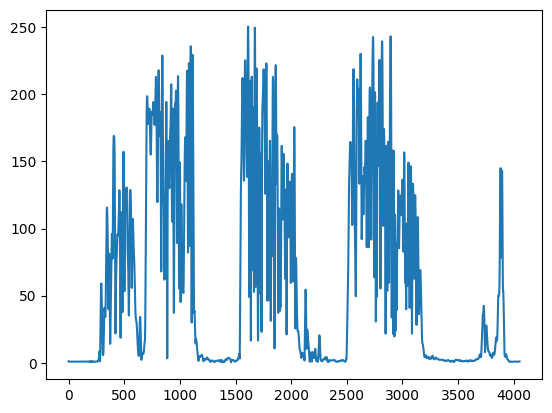

In [175]:
plt.plot(vel_res_id)

In [176]:
total_idle_time, idle_instances, idle_periods = generate_Idle_time(vel_res_id, params)

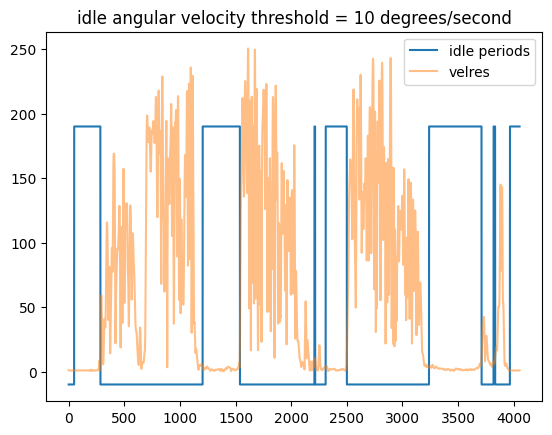

In [188]:
plt.plot(idle_periods * 200 - 10, label='idle periods')
plt.plot(vel_res_id, alpha=0.5, label='magnitude of angular velocity')
plt.title('idle angular velocity threshold = 10 degrees/second')
plt.legend()


([<matplotlib.axis.XTick at 0x2a0348250>,
 [Text(1, 0, 'calculated with angular velocity'), Text(2, 0, 'ground truth')])

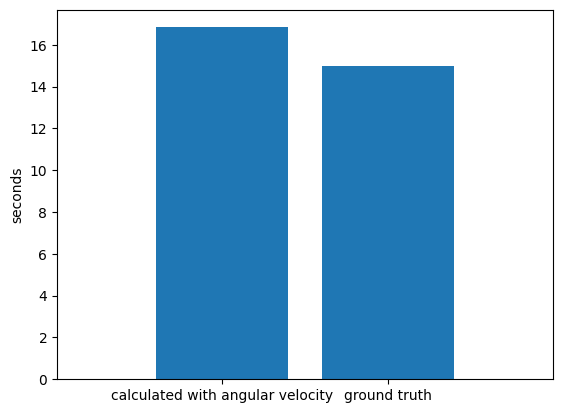

In [200]:
plt.bar([1, 2], [total_idle_time, 15])
plt.xlim(0, 3)
plt.ylabel('seconds')
plt.xticks([1, 2],['calculated with angular velocity', 'ground truth'])